## Libraries

In [ ]:
import geopandas as gpd
import shapely
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import momepy
import os
import networkx as nx
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Pittsburgh Road Network Data

In [2]:
cwd = os.getcwd() 

In [3]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/SPC_GIS/')
os.chdir(new_dir)

In [4]:
# input: filename of shapefile (assuming already in correct directory) 
# output: geopandas dataframe 
def read_file(filename):
    # Set filename
    filename = filename
    # Read file 
    data_out = gpd.read_file(filename)
    return data_out

In [5]:
nodes = read_file("new_node.shp")
edges = read_file("new_link.shp")

In [6]:
nodes.head(3)
len(nodes)
edges.head(3)
len(edges)

,ID,isOD,geometry
0,1,0,POINT (-79.83845 40.54487)
1,3,0,POINT (-80.03123 40.45891)
2,4,0,POINT (-79.06545 40.53644)


6014

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
0,8290,1,2114,25,1,0.04,0,8290,1388147.792,448212.542,1387767.306,449855.597,"LINESTRING (1388147.792 448212.542, 1388478.88..."
1,8291,1,5550,25,1,0.02,0,8291,1388147.792,448212.542,1388249.875,447637.094,"LINESTRING (1388147.792 448212.542, 1388135.13..."
2,1008267,1,1767,35,2,0.06,0,1008267+8266,1388147.792,448212.542,1387621.732,446190.858,"LINESTRING (1388147.792 448212.542, 1387932.01..."


16110

<AxesSubplot:>

<AxesSubplot:>

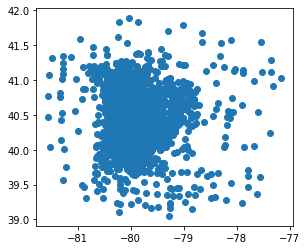

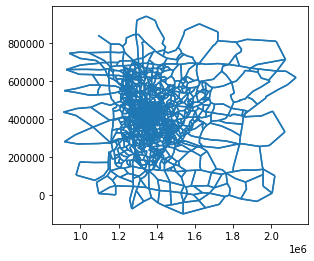

In [7]:
nodes.plot()
#nodes.crs
edges.plot()

## "Clip" the data: subset PGH road network by selected neighborhoods

In [8]:
new_dir = cwd.replace('Code', 'Data/PGH_neighborhoods/')
os.chdir(new_dir)

<AxesSubplot:>

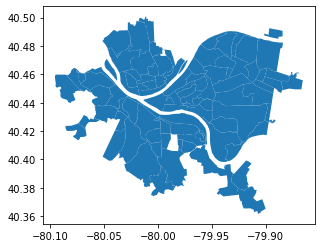

In [9]:
pgh_nhoods = read_file("Neighborhoods_.shp")   # https://data.wprdc.org/dataset/neighborhoods2
pgh_nhoods.plot()  # this is a polygon layer

In [10]:
# Select a subset of neighborhoods for which the analysis will be conducted
hood_list = pgh_nhoods['hood'].tolist()
hood_keep = ['Squirrel Hill North', 'Shadyside', 'East Liberty']  # smaller list for testing
# hood_keep = ["Central Oakland", 'North Oakland', 'South Oakland', 'Bloomfield', 'Garfield', 'Friendship', 'East Liberty', 
#              'Larimer', 'Shadyside', 'Squirrel Hill North', 'Squirrel Hill South', 'Greenfield', 'Hazelwood', 
#              'Glen Hazel']
pgh_nhoods_mask = pgh_nhoods[pgh_nhoods['hood'].isin(hood_keep)]  # subset the nhood polygon layer

77

<AxesSubplot:>

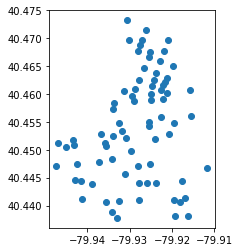

In [11]:
# clip the nodes: only include those within the selected neighborhoods
nodes_clip = gpd.clip(nodes, pgh_nhoods_mask)  
len(nodes_clip)
nodes_clip.plot()

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

275

<AxesSubplot:>

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.250,414950.448,1361962.042,414213.990,"LINESTRING (-79.92393 40.45198, -79.92723 40.4..."
76,1003094,37,2894,20,1,0.02,0,1003094,1363567.250,414950.448,1363194.022,415773.493,"LINESTRING (-79.92393 40.45198, -79.92534 40.4..."
77,3097,37,727,25,2,0.02,0,3097,1363567.250,414950.448,1364456.833,415271.281,"LINESTRING (-79.92393 40.45198, -79.92196 40.4..."
117,1002803,59,1594,25,1,0.02,0,1002803,1362395.028,412111.181,1362391.556,410951.458,"LINESTRING (-79.92789 40.44410, -79.92780 40.4..."
118,1003119,59,187,25,1,0.02,0,1003119,1362395.028,412111.181,1361484.611,412697.323,"LINESTRING (-79.92789 40.44410, -79.93121 40.4..."


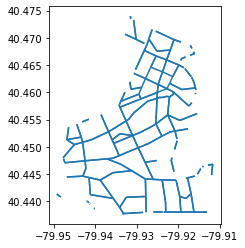

In [12]:
# The geometry of edges has a diferent coordinate ref system than the geometry of nodes and neighborhoods
# edges.crs
# pgh_nhoods_mask.crs
# nodes.crs

# Transform geometry of edges to the proper coord system
edges = edges.to_crs(epsg = 4326)
edges.crs

# Now edges can be clipped appropriately
edges_clip = gpd.clip(edges, pgh_nhoods_mask)
len(edges_clip)
edges_clip.plot()
edges_clip.head(5)

In [13]:
def plot_nodes_and_edges(nodes_df, edges_df):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    edges_df.plot(ax=ax, color = 'darkgray', zorder=1)
    nodes_df.plot(ax=ax, color = 'black', zorder=2)
    return ax

<AxesSubplot:>

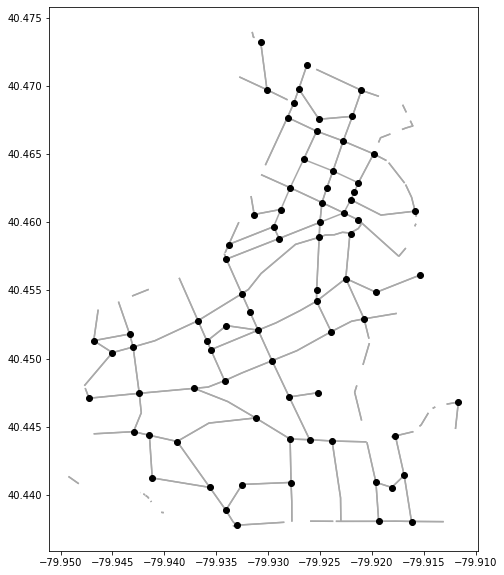

In [14]:
plot_nodes_and_edges(nodes_clip, edges_clip)

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.25,414950.448,1361962.042,414213.990,"LINESTRING (-79.92393 40.45198, -79.92723 40.4..."
76,1003094,37,2894,20,1,0.02,0,1003094,1363567.25,414950.448,1363194.022,415773.493,"LINESTRING (-79.92393 40.45198, -79.92534 40.4..."
77,3097,37,727,25,2,0.02,0,3097,1363567.25,414950.448,1364456.833,415271.281,"LINESTRING (-79.92393 40.45198, -79.92196 40.4..."


<AxesSubplot:>

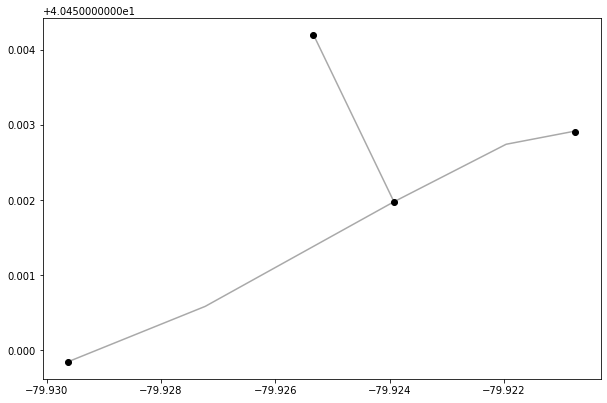

In [15]:
# Are 'N1' and 'N2' in edges df equivalent to 'ID' in nodes df? Test:
edges_clip = edges_clip.astype({'N1':'int32', 'N2':'int32'})
eclip_test = edges_clip[edges_clip['N1'] == 37]
eclip_test
nclip_test = nodes_clip[((nodes_clip['ID'] == 37) | (nodes_clip['ID'] == 3461) | (nodes_clip['ID'] == 2894) | (nodes_clip['ID'] == 727))]

plot_nodes_and_edges(nclip_test, eclip_test)
# this plot confirms that N1 and N2 columns in edges df are equivalent to ID column in nodes df

In [16]:
nodes_clip.loc[27]['geometry'].x
nodes_clip.loc[27]['geometry'].y

-79.923923

40.451967

## Convert geopandas df to networkx graph
### Why? The small network test code was written using the networkx graph object

In [17]:
# helper function when converting gpd df to networkx graph
def nx_pos(x, y):
    return {'pos': (x,y)}

In [18]:
nodes_clip.columns

Index(['ID', 'isOD', 'geometry'], dtype='object')

In [19]:
# add x-y columns for coordinates 
nodes_clip['x'] = nodes_clip.apply(lambda p: p['geometry'].x, axis=1)
nodes_clip['y'] = nodes_clip.apply(lambda p: p['geometry'].y, axis=1)
nodes_clip['nx_pos'] = nodes_clip.apply(lambda p: nx_pos(p['x'], p['y']), axis=1)
nodes_clip.columns

Index(['ID', 'isOD', 'geometry', 'x', 'y', 'nx_pos'], dtype='object')

In [20]:
nodes_clip.head(3)

,ID,isOD,geometry,x,y,nx_pos
27,37,0,POINT (-79.92392 40.45197),-79.923923,40.451967,"{'pos': (-79.923923, 40.451967)}"
42,59,0,POINT (-79.92788 40.44410),-79.927882,40.444097,"{'pos': (-79.927882, 40.444097)}"
127,187,0,POINT (-79.93120 40.44564),-79.931204,40.445643,"{'pos': (-79.931204, 40.445643)}"


In [21]:
# add nodes to the graph, including their positions 
graph_nodes = list(zip(nodes_clip.ID.tolist(), nodes_clip.nx_pos.tolist()))
G = nx.DiGraph()
G.add_nodes_from(graph_nodes)
G.nodes[37]['pos']

(-79.923923, 40.451967)

In [22]:
def nx_edge_attr(linkID, speed):
    attr_dict = {'linkID': linkID, 'speed':speed}
    return attr_dict

In [23]:
#edges_clip['edge'] = edges_clip.apply(lambda l: (l['N1'], l['N2']), axis=1)
edges_clip['attr'] = edges_clip.apply(lambda l: nx_edge_attr(l['linkID'], l['spd']), axis=1)# only include edges if the nodes they connect are also in the graph
edges_clip_subset = edges_clip[(edges_clip['N1'].isin(G.nodes)) & (edges_clip['N2'].isin(G.nodes))]
edges_clip_subset.head()
edges_clip_subset.shape

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry,attr
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.250,414950.448,1361962.042,414213.990,"LINESTRING (-79.92393 40.45198, -79.92723 40.4...","{'linkID': '1003090', 'speed': '25'}"
76,1003094,37,2894,20,1,0.02,0,1003094,1363567.250,414950.448,1363194.022,415773.493,"LINESTRING (-79.92393 40.45198, -79.92534 40.4...","{'linkID': '1003094', 'speed': '20'}"
77,3097,37,727,25,2,0.02,0,3097,1363567.250,414950.448,1364456.833,415271.281,"LINESTRING (-79.92393 40.45198, -79.92196 40.4...","{'linkID': '3097', 'speed': '25'}"
117,1002803,59,1594,25,1,0.02,0,1002803,1362395.028,412111.181,1362391.556,410951.458,"LINESTRING (-79.92789 40.44410, -79.92780 40.4...","{'linkID': '1002803', 'speed': '25'}"
118,1003119,59,187,25,1,0.02,0,1003119,1362395.028,412111.181,1361484.611,412697.323,"LINESTRING (-79.92789 40.44410, -79.93121 40.4...","{'linkID': '1003119', 'speed': '25'}"


(195, 14)

In [24]:
graph_edges = list(zip(edges_clip_subset['N1'].tolist(), edges_clip_subset['N2'].tolist(),
                       edges_clip_subset['attr'].tolist()))
graph_edges[:5]

[(37, 3461, {'linkID': '1003090', 'speed': '25'}),
 (37, 2894, {'linkID': '1003094', 'speed': '20'}),
 (37, 727, {'linkID': '3097', 'speed': '25'}),
 (59, 1594, {'linkID': '1002803', 'speed': '25'}),
 (59, 187, {'linkID': '1003119', 'speed': '25'})]

In [29]:
# add edges to the graph, including their ID and speed limit
G.add_edges_from(graph_edges)

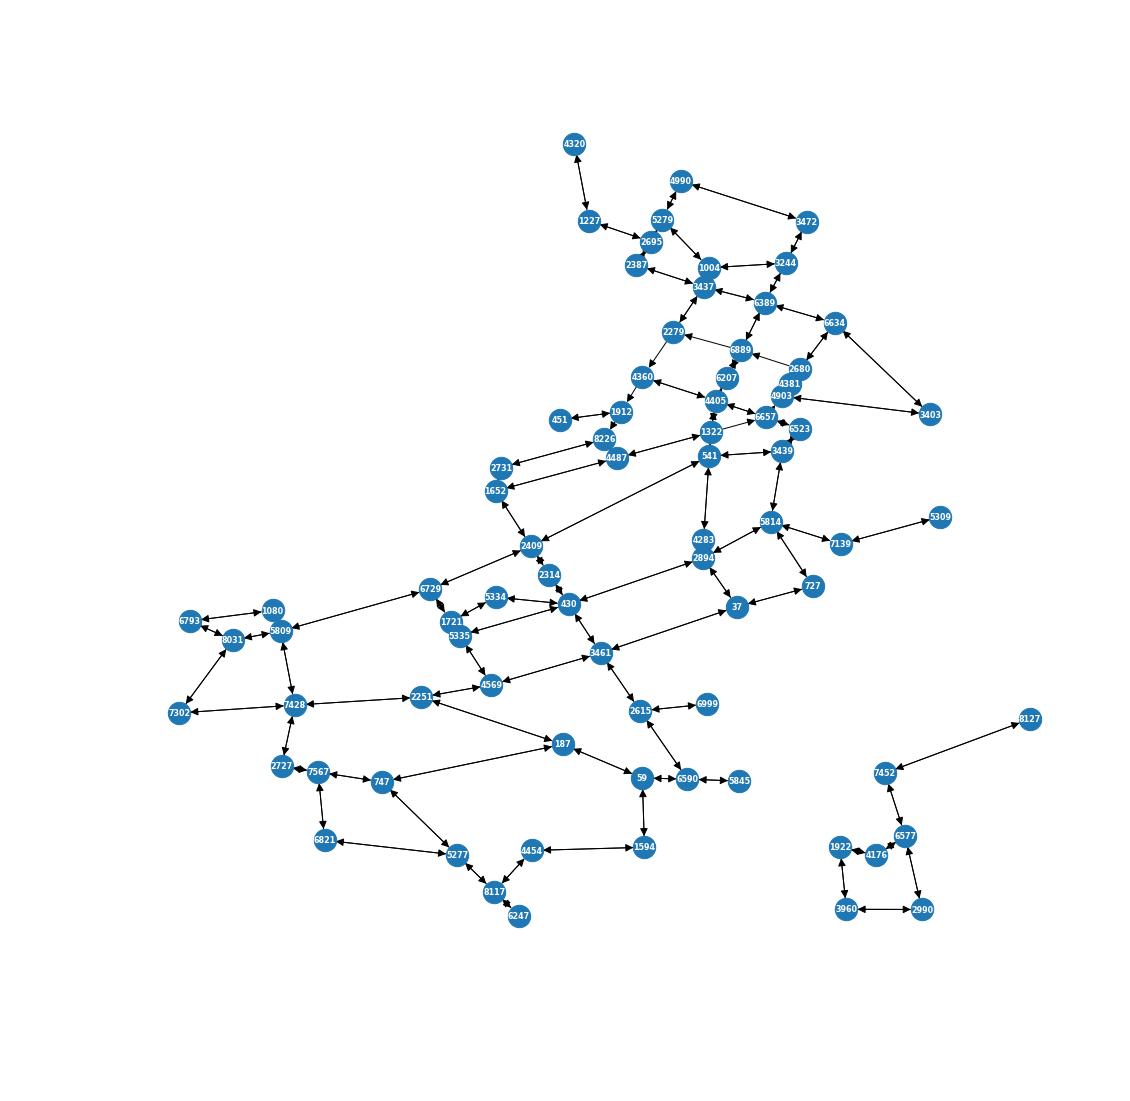

In [31]:
# draw the graph in networkx
node_coords = nx.get_node_attributes(G, 'pos')
fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, pos=node_coords, with_labels=True, font_color='white', font_size=8,  font_weight = 'bold',
        node_size=500, arrowsize=16, ax=ax)

## Bikeshare Data

In [43]:
# Healthy Ride depots:  https://data.wprdc.org/dataset/healthyride-stations
cwd

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Code'

In [44]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/')
os.chdir(new_dir)
os.getcwd()

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data'

In [51]:
filename = 'pgh_bikeshare_depot_q3_2021.csv'
bs_df = pd.read_csv(filename)
bs_df.head()

,Station #,Station Name,# of Racks,Latitude,Longitude
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080
2,1002,Third Ave & Wood St,15,40.439030,-80.001860
3,1003,First Ave & Smithfield St,9,40.437200,-80.000375
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102


In [53]:
# add position column, to be used when converting to networkx graph object
bs_df['nx_pos'] = bs_df.apply(lambda p: nx_pos(p['Longitude'], p['Latitude']), axis=1)

<AxesSubplot:>

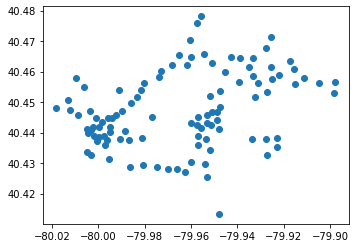

In [58]:
# generate point geometry from x,y coords, so that the GIS clip function can be used to only 
# include depots within the study region
bs_df['geometry'] = gpd.points_from_xy(bs_df.Longitude, bs_df.Latitude, crs="EPSG:4326")
bs_gdf = gpd.GeoDataFrame(bs_df)  # convert to geo df
bs_gdf.plot()

<AxesSubplot:>

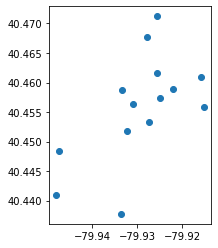

In [73]:
# Clip the bs node network
bs_depots_clip = gpd.clip(bs_gdf, pgh_nhoods_mask)
bs_depots_clip.plot()

In [69]:
# Back to the original road network...
# Find the "bike-friendly" streets, i.e. those with a speed limit <= 40
bike_speedlim_max = 40
edges_clip['spd'] = edges_clip['spd'].astype('float')
bike_edges = edges_clip[edges_clip['spd'] <= bike_speedlim_max]
edges_clip.shape
bike_edges.shape  # no reduction in roads with a max speed limit of 40...could lower the max speed limit if desired

(275, 14)

(275, 14)

<AxesSubplot:>

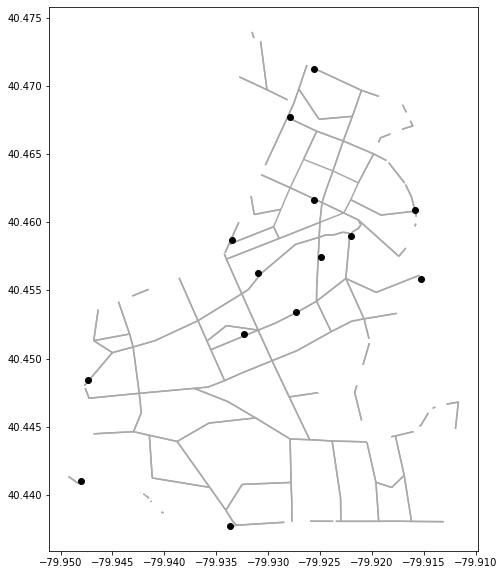

In [74]:
plot_nodes_and_edges(bs_depots_clip, edges_clip)

In [81]:
edges_clip.sindex

In [133]:
from shapely.geometry import box, LineString, Point,MultiPoint
from shapely.ops import nearest_points

In [132]:
df = gpd.GeoDataFrame([[0, 'location A', Point(55,55)], 
                       [1, 'location B', Point(66,66)],
                       [2, 'Location C', Point(99,99)],
                       [3, 'Location D' ,Point(11,11)]], 
                      columns=['ID','Location','geometry'])
df.insert(3, 'nearest_geometry', None)
df.head(5)

for index, row in df.iterrows():
    point = row.geometry
    multipoint = df.drop(index, axis=0).geometry.unary_union
    queried_geom, nearest_geom = nearest_points(point, multipoint)
    df.loc[index, 'nearest_geometry'] = nearest_geom
df.head()

,ID,Location,geometry,nearest_geometry
0,0,location A,POINT (55.000 55.000),None
1,1,location B,POINT (66.000 66.000),None
2,2,Location C,POINT (99.000 99.000),None
3,3,Location D,POINT (11.000 11.000),None


,ID,Location,geometry,nearest_geometry
0,0,location A,POINT (55.000 55.000),POINT (66 66)
1,1,location B,POINT (66.000 66.000),POINT (55 55)
2,2,Location C,POINT (99.000 99.000),POINT (66 66)
3,3,Location D,POINT (11.000 11.000),POINT (55 55)


Snap the bikeshare depots to the nearest nodes in the road network. This is an approximation. <br>
I cannot yet figure out how to snap them to the nearest line. <br>
Other idea to try at some point: 1) find nearest node in the road network relative to the given bikeshare depot. 2) calc distance between depot and node. 3) if dist exceeds some value, find nearest line centroid relative to the given bikeshare depot. 4) choose the closer node: road network node or line centroid. 4) if line centroid is chosen, need to build edges from depot to line start node and depot to line end node <br>
See: gpd.centroid() and gpd.represenative_point()

In [ ]:
# prepare data
bike_nodes = nodes_clip.copy()   # intersection nodes in the biking network 
bike_nodes['isDepot'] = 'N'
bike_nodes_union = bike_nodes.geometry.unary_union  # returns a multipoint

In [188]:
# https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
def near(input_point, multipoint):
    nn = nearest_points(input_point, bike_nodes_union)[1]  # returns the nn point as a geometry
    dist = input_point.distance(nn)  # nearest neighbor distance 
    return (nn, dist)

<AxesSubplot:>

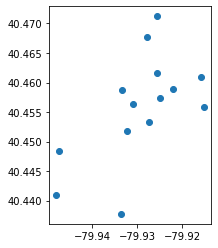

In [209]:
bs_depots_clip.plot()

In [202]:
bs_depots_clip['nn'] = bs_depots_clip.apply(lambda row: near(row['geometry'], bike_nodes_union)[0], axis=1)
# map back to original bike network node data
all_nn = gpd.GeoDataFrame(bs_depots_clip['nn'].rename('geometry')).geometry.unary_union  # a multipoint of all nn points
bike_nodes['isDepot'] = bike_nodes.apply(lambda row: 'Y' if all_nn.contains(row['geometry']) else 'N', axis=1)
#all_nn.rename('geometry', inplace=True)
#bike_nodes['isDepot'] = bike_nodes.apply(lambda row: row['geometry']  , axis=1)

In [211]:
depot_approx = bike_nodes[bike_nodes['isDepot'] == 'Y']

<AxesSubplot:>

<AxesSubplot:>

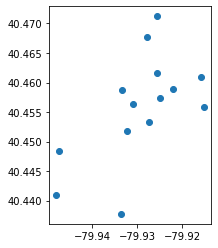

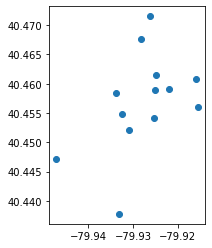

In [213]:
bs_depots_clip.plot()
depot_approx.plot()

In [205]:
bike_nodes[bike_nodes['isDepot'] == 'Y'].shape

(13, 7)

In [190]:
#(bike_nodes.loc[bike_nodes['geometry'] == nn]['geometry']) in all_nn

In [ ]:
# Note that in the figure of nodes_clip and edges_clip, there are some detached roads. Let's only include a fully connected network
nodes_included = nodes_clip['ID'].tolist()
node_mask = edges_clip['N1'].isin(nodes_included) | edges_clip['N2'].isin(nodes_included)
new_edges_clip = edges_clip[node_mask]
len(new_edges_clip)
plot_nodes_and_edges(nodes_clip, new_edges_clip)